In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, mobilenetv3, utils, metrics, train

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - Mobile Net V3 Large pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

In [2]:
show_pic = False

if show_pic:
    Image.open('../model_architecture.png')

In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


### Initialize Dataset and Dataloader

In [4]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [5]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 'gender' : gender_dict, 'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, {'age_dict' : age_dict, 'race_dict' : race_dict, 'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [6]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels.head()

,file,age,gender,race,age_weight,gender_weight,race_weight,total_weight,group,count,group_weight
0,train/1.jpg,6,0,3,0.000202,0.000027,0.000102,0.000330,603,272,0.003676
1,train/2.jpg,4,1,2,0.000065,0.000031,0.000102,0.000197,412,931,0.001074
2,train/4.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
3,train/5.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
4,train/7.jpg,5,0,6,0.000116,0.000027,0.000136,0.000279,506,961,0.001041


In [7]:
train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], axis=1)

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041
...,...,...,...,...,...,...,...
69390,train/86738.jpg,2,0,2,202,510,0.001961
69391,train/86741.jpg,2,0,2,202,510,0.001961
69392,train/86742.jpg,8,1,2,812,93,0.010753
69393,train/86743.jpg,2,1,4,214,663,0.001508


In [24]:
root_dir = Path('..')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 480

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomGrayscale(p=0.2),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

In [25]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
val_label = pd.read_csv('../data/fairface_label_val.csv')

In [26]:
import json

with open('../train_test_val.json', 'r') as f:
    train_test = json.load(f)

In [27]:
print('Train Age Class Distribution')
print(train_label.loc[train_label['file'].isin(train_test['train']), 'age'].value_counts(normalize=True).to_string(), end='\n\n')
print('Dev Age Class Distribution')
print(train_label.loc[train_label['file'].isin(train_test['test']), 'age'].value_counts(normalize=True).to_string())
print('Test Age Class Distribution')
print(val_label.loc[val_label['file'].isin(train_test['val']), 'age'].value_counts(normalize=True).to_string())


Train Age Class Distribution
age
20-29           0.295108
30-39           0.222192
40-49           0.124029
3-9             0.119980
10-19           0.104561
50-59           0.071504
60-69           0.032178
0-2             0.020967
more than 70    0.009482

Dev Age Class Distribution
age
20-29           0.295060
30-39           0.220820
40-49           0.123177
3-9             0.120007
10-19           0.106461
50-59           0.072973
60-69           0.031472
0-2             0.019425
more than 70    0.010606
Test Age Class Distribution
age
20-29           0.301260
30-39           0.212708
3-9             0.123790
40-49           0.123517
10-19           0.107814
50-59           0.072668
60-69           0.029304
0-2             0.018167
more than 70    0.010772


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


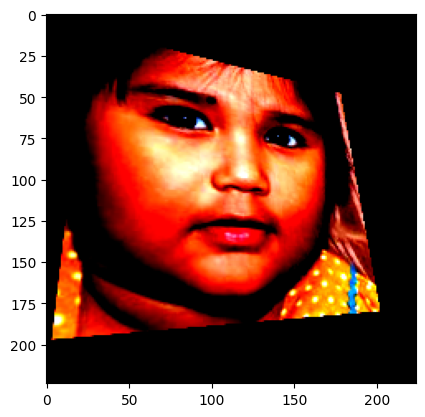

In [28]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 35)

### Sample data

In [29]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)
model = mobilenetv3.FairFaceMobileNet(mobilenet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


### Train model

In [31]:
# map ages
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}


class_dicts = {'age' : age_dict, 
               'race' : race_dict, 
               'gender': gender_dict}
# train the model
best_model = train.train_model(model, criterion, 
                               optimizer, scheduler_lr=scheduler, 
                               device=device, loaders=[train_loader, test_loader],
                               tensor_writer=writer, mappings=mappings, class_dicts=class_dicts,
                               class_weights=class_weights, n_epochs=35)

100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 1, Loss = 5.716862201690674
Age accuracy = 0.13146480293969307	Race accuracy = 0.14194106203616974	Gender accuracy = 0.5421283954175373
Age loss = 2.1342828273773193	Race loss = 1.9559903144836426	Gender Loss = 0.6876608729362488


100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Validation step:
Epoch = 1, Loss = 5.799333533725223
Age accuracy = 0.10525102311372414	Race accuracy = 0.1431206409591331	Gender accuracy = 0.6556573865928872
Age loss = 2.197373151779175	Race loss = 1.9559009075164795	Gender Loss = 0.6511191725730896
End of Epoch: 1 	Training Loss: 5.716862201690674 	Validation Loss: 5.799333533725223
Validation loss decreased (inf --> 5.799333533725223).  Saving model ...


100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 2, Loss = 5.44156551361084
Age accuracy = 0.18322645723755313	Race accuracy = 0.18978312558541682	Gender accuracy = 0.7115210029541034
Age loss = 2.0078694820404053	Race loss = 1.9160236120224	Gender Loss = 0.5697406530380249


100%|██████████| 37/37 [00:09<00:00,  3.82it/s]


Validation step:
Epoch = 2, Loss = 5.3037898347184464
Age accuracy = 0.22076200357369302	Race accuracy = 0.2613983514899994	Gender accuracy = 0.7878840278978615
Age loss = 2.0162100791931152	Race loss = 1.8227142095565796	Gender Loss = 0.44514936208724976
End of Epoch: 2 	Training Loss: 5.44156551361084 	Validation Loss: 5.3037898347184464
Validation loss decreased (5.799333533725223 --> 5.3037898347184464).  Saving model ...


100%|██████████| 145/145 [01:00<00:00,  2.41it/s]


Training step:
Epoch = 3, Loss = 5.055213451385498
Age accuracy = 0.26542258087758486	Race accuracy = 0.24761149938756394	Gender accuracy = 0.8058217450824987
Age loss = 1.8656665086746216	Race loss = 1.8051671981811523	Gender Loss = 0.43839016556739807


100%|██████████| 37/37 [00:10<00:00,  3.62it/s]


Validation step:
Epoch = 3, Loss = 4.670209833093591
Age accuracy = 0.3405383595596288	Race accuracy = 0.3316041270390224	Gender accuracy = 0.8587238457547985
Age loss = 1.742598533630371	Race loss = 1.6695071458816528	Gender Loss = 0.31208664178848267
End of Epoch: 3 	Training Loss: 5.055213451385498 	Validation Loss: 4.670209833093591
Validation loss decreased (5.3037898347184464 --> 4.670209833093591).  Saving model ...


100%|██████████| 145/145 [01:01<00:00,  2.35it/s]


Training step:
Epoch = 4, Loss = 4.693451881408691
Age accuracy = 0.3288277253404424	Race accuracy = 0.29445925498955255	Gender accuracy = 0.8397723178903379
Age loss = 1.724643588066101	Race loss = 1.6962249279022217	Gender Loss = 0.3694043457508087


100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Validation step:
Epoch = 4, Loss = 4.419107759321058
Age accuracy = 0.33535074067669607	Race accuracy = 0.36826330047841377	Gender accuracy = 0.8727880569485273
Age loss = 1.645341396331787	Race loss = 1.5851584672927856	Gender Loss = 0.2923056483268738
End of Epoch: 4 	Training Loss: 4.693451881408691 	Validation Loss: 4.419107759321058
Validation loss decreased (4.670209833093591 --> 4.419107759321058).  Saving model ...


100%|██████████| 145/145 [01:01<00:00,  2.36it/s]


Training step:
Epoch = 5, Loss = 4.421350479125977
Age accuracy = 0.36813891490741407	Race accuracy = 0.32415880106635925	Gender accuracy = 0.8541105266950069
Age loss = 1.6067842245101929	Race loss = 1.62187659740448	Gender Loss = 0.3441753685474396


100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


Validation step:
Epoch = 5, Loss = 4.0812687100590885
Age accuracy = 0.40227102426652833	Race accuracy = 0.39529655887947435	Gender accuracy = 0.8790708398178569
Age loss = 1.4978299140930176	Race loss = 1.4902032613754272	Gender Loss = 0.27571502327919006
End of Epoch: 5 	Training Loss: 4.421350479125977 	Validation Loss: 4.0812687100590885
Validation loss decreased (4.419107759321058 --> 4.0812687100590885).  Saving model ...


100%|██████████| 145/145 [01:02<00:00,  2.33it/s]


Training step:
Epoch = 6, Loss = 4.204681396484375
Age accuracy = 0.40093666690683766	Race accuracy = 0.35215793645075294	Gender accuracy = 0.8638950933064342
Age loss = 1.5204826593399048	Race loss = 1.5537570714950562	Gender Loss = 0.32139649987220764


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


Validation step:
Epoch = 6, Loss = 3.8041448657577104
Age accuracy = 0.46613637673641134	Race accuracy = 0.43051472707360655	Gender accuracy = 0.8831632947143928
Age loss = 1.3837138414382935	Race loss = 1.4024921655654907	Gender Loss = 0.2656327188014984
End of Epoch: 6 	Training Loss: 4.204681396484375 	Validation Loss: 3.8041448657577104
Validation loss decreased (4.0812687100590885 --> 3.8041448657577104).  Saving model ...


100%|██████████| 145/145 [01:01<00:00,  2.34it/s]


Training step:
Epoch = 7, Loss = 4.006638526916504
Age accuracy = 0.4233590316305209	Race accuracy = 0.3890337920599467	Gender accuracy = 0.87098494127819
Age loss = 1.4523857831954956	Race loss = 1.4757790565490723	Gender Loss = 0.30726706981658936


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


Validation step:
Epoch = 7, Loss = 3.706540874532751
Age accuracy = 0.4525332872211655	Race accuracy = 0.48579168828174535	Gender accuracy = 0.8877745114992218
Age loss = 1.3652981519699097	Race loss = 1.344381332397461	Gender Loss = 0.2595997750759125
End of Epoch: 7 	Training Loss: 4.006638526916504 	Validation Loss: 3.706540874532751
Validation loss decreased (3.8041448657577104 --> 3.706540874532751).  Saving model ...


100%|██████████| 145/145 [00:59<00:00,  2.44it/s]


Training step:
Epoch = 8, Loss = 3.848745584487915
Age accuracy = 0.4404207795950717	Race accuracy = 0.4203472872685352	Gender accuracy = 0.8795158152604654
Age loss = 1.3990918397903442	Race loss = 1.4138784408569336	Gender Loss = 0.2905152142047882


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Validation step:
Epoch = 8, Loss = 3.5843412747254244
Age accuracy = 0.4628508847772206	Race accuracy = 0.5087901319960805	Gender accuracy = 0.8912329240878437
Age loss = 1.318423867225647	Race loss = 1.3011609315872192	Gender Loss = 0.25559812784194946
End of Epoch: 8 	Training Loss: 3.848745584487915 	Validation Loss: 3.5843412747254244
Validation loss decreased (3.706540874532751 --> 3.5843412747254244).  Saving model ...


100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 9, Loss = 3.7069015502929688
Age accuracy = 0.45519129620289644	Race accuracy = 0.4421067800273795	Gender accuracy = 0.8854096116434902
Age loss = 1.3469902276992798	Race loss = 1.3628143072128296	Gender Loss = 0.2785548269748688


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Validation step:
Epoch = 9, Loss = 3.457943871214583
Age accuracy = 0.47334140296270677	Race accuracy = 0.5106346187100121	Gender accuracy = 0.886852268142256
Age loss = 1.2619233131408691	Race loss = 1.265306830406189	Gender Loss = 0.2565164268016815
End of Epoch: 9 	Training Loss: 3.7069015502929688 	Validation Loss: 3.457943871214583
Validation loss decreased (3.5843412747254244 --> 3.457943871214583).  Saving model ...


100%|██████████| 145/145 [01:00<00:00,  2.40it/s]


Training step:
Epoch = 10, Loss = 3.5914323329925537
Age accuracy = 0.46660422220621084	Race accuracy = 0.4606239642625549	Gender accuracy = 0.8876720224800058
Age loss = 1.306448221206665	Race loss = 1.318414568901062	Gender Loss = 0.27034619450569153


100%|██████████| 37/37 [00:08<00:00,  4.15it/s]


Validation step:
Epoch = 10, Loss = 3.346660246720185
Age accuracy = 0.494610640382731	Race accuracy = 0.526946798086345	Gender accuracy = 0.8941149345783619
Age loss = 1.2235928773880005	Race loss = 1.2223844528198242	Gender Loss = 0.24570205807685852
End of Epoch: 10 	Training Loss: 3.5914323329925537 	Validation Loss: 3.346660246720185
Validation loss decreased (3.457943871214583 --> 3.346660246720185).  Saving model ...


100%|██████████| 145/145 [01:00<00:00,  2.41it/s]


Training step:
Epoch = 11, Loss = 3.477489948272705
Age accuracy = 0.4778298148281577	Race accuracy = 0.4755818142517472	Gender accuracy = 0.8923265364939837
Age loss = 1.2618762254714966	Race loss = 1.2802116870880127	Gender Loss = 0.26311251521110535


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Validation step:
Epoch = 11, Loss = 3.322622975787601
Age accuracy = 0.4877514554152977	Race accuracy = 0.5282725229119833	Gender accuracy = 0.8942302149979826
Age loss = 1.2265766859054565	Race loss = 1.1980688571929932	Gender Loss = 0.24550804495811462
End of Epoch: 11 	Training Loss: 3.477489948272705 	Validation Loss: 3.322622975787601
Validation loss decreased (3.346660246720185 --> 3.322622975787601).  Saving model ...


100%|██████████| 145/145 [00:59<00:00,  2.42it/s]


Training step:
Epoch = 12, Loss = 3.378142833709717
Age accuracy = 0.4951653577347071	Race accuracy = 0.4954247424166006	Gender accuracy = 0.8945313062900785
Age loss = 1.228326678276062	Race loss = 1.2410272359848022	Gender Loss = 0.2534901201725006


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Validation step:
Epoch = 12, Loss = 3.333668863451159
Age accuracy = 0.4679232232405326	Race accuracy = 0.5377831575306934	Gender accuracy = 0.897630987376794
Age loss = 1.2383629083633423	Race loss = 1.193532109260559	Gender Loss = 0.2414909154176712
End of Epoch: 12 	Training Loss: 3.378142833709717 	Validation Loss: 3.333668863451159


100%|██████████| 145/145 [00:59<00:00,  2.45it/s]


Training step:
Epoch = 13, Loss = 3.2865161895751953
Age accuracy = 0.507428489084228	Race accuracy = 0.5137834137906189	Gender accuracy = 0.8968657684271201
Age loss = 1.1999247074127197	Race loss = 1.2012959718704224	Gender Loss = 0.24580232799053192


100%|██████████| 37/37 [00:08<00:00,  4.34it/s]


Validation step:
Epoch = 13, Loss = 3.2591760416288635
Age accuracy = 0.490806386535247	Race accuracy = 0.5460257075335754	Gender accuracy = 0.8995331143005361
Age loss = 1.202711582183838	Race loss = 1.1761677265167236	Gender Loss = 0.23937055468559265
End of Epoch: 13 	Training Loss: 3.2865161895751953 	Validation Loss: 3.2591760416288635
Validation loss decreased (3.322622975787601 --> 3.2591760416288635).  Saving model ...


100%|██████████| 145/145 [00:58<00:00,  2.49it/s]


Training step:
Epoch = 14, Loss = 3.2122459411621094
Age accuracy = 0.5163916708696592	Race accuracy = 0.5256862886375099	Gender accuracy = 0.9017940773830968
Age loss = 1.1724507808685303	Race loss = 1.1744877099990845	Gender Loss = 0.2406642735004425


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Validation step:
Epoch = 14, Loss = 3.199569083548881
Age accuracy = 0.5116145022767883	Race accuracy = 0.5448729033373682	Gender accuracy = 0.9010893999654159
Age loss = 1.169871211051941	Race loss = 1.1665488481521606	Gender Loss = 0.242121160030365
End of Epoch: 14 	Training Loss: 3.2122459411621094 	Validation Loss: 3.199569083548881
Validation loss decreased (3.2591760416288635 --> 3.199569083548881).  Saving model ...


100%|██████████| 145/145 [00:57<00:00,  2.53it/s]


Training step:
Epoch = 15, Loss = 3.1567556858062744
Age accuracy = 0.5213199798256358	Race accuracy = 0.540327112904388	Gender accuracy = 0.9025578211686721
Age loss = 1.1565624475479126	Race loss = 1.1482691764831543	Gender Loss = 0.23769055306911469


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Validation step:
Epoch = 15, Loss = 3.286156564145475
Age accuracy = 0.5019885872384575	Race accuracy = 0.5450458239667992	Gender accuracy = 0.8978615482160355
Age loss = 1.2021894454956055	Race loss = 1.19598388671875	Gender Loss = 0.25324735045433044
End of Epoch: 15 	Training Loss: 3.1567556858062744 	Validation Loss: 3.286156564145475


100%|██████████| 145/145 [00:57<00:00,  2.54it/s]


Training step:
Epoch = 16, Loss = 3.078031539916992
Age accuracy = 0.5332084444124217	Race accuracy = 0.5482383457021399	Gender accuracy = 0.9089703869154838
Age loss = 1.1253384351730347	Race loss = 1.1249396800994873	Gender Loss = 0.2237720936536789


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Validation step:
Epoch = 16, Loss = 3.1851673641720333
Age accuracy = 0.5127673064729955	Race accuracy = 0.5544988183756989	Gender accuracy = 0.90016715660845
Age loss = 1.1688132286071777	Race loss = 1.1537829637527466	Gender Loss = 0.24854984879493713
End of Epoch: 16 	Training Loss: 3.078031539916992 	Validation Loss: 3.1851673641720333
Validation loss decreased (3.199569083548881 --> 3.1851673641720333).  Saving model ...


100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Training step:
Epoch = 17, Loss = 3.027431011199951
Age accuracy = 0.5440305497514231	Race accuracy = 0.556596296563153	Gender accuracy = 0.9090424382160098
Age loss = 1.106011152267456	Race loss = 1.1067622900009155	Gender Loss = 0.2227378636598587


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


Validation step:
Epoch = 17, Loss = 3.2234760232873865
Age accuracy = 0.48988414317828116	Race accuracy = 0.5564009452994408	Gender accuracy = 0.8994754740907257
Age loss = 1.1893471479415894	Race loss = 1.1605383157730103	Gender Loss = 0.24735096096992493
End of Epoch: 17 	Training Loss: 3.027431011199951 	Validation Loss: 3.2234760232873865


100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 18, Loss = 2.970425605773926
Age accuracy = 0.550169320556236	Race accuracy = 0.5643346062396426	Gender accuracy = 0.9121550543987319
Age loss = 1.0884214639663696	Race loss = 1.0822466611862183	Gender Loss = 0.21686507761478424


100%|██████████| 37/37 [00:08<00:00,  4.22it/s]


Validation step:
Epoch = 18, Loss = 3.220411339321652
Age accuracy = 0.5036601533229581	Race accuracy = 0.5517897285146118	Gender accuracy = 0.9004553576575018
Age loss = 1.1767131090164185	Race loss = 1.176439881324768	Gender Loss = 0.23911185562610626
End of Epoch: 18 	Training Loss: 2.970425605773926 	Validation Loss: 3.220411339321652


100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 19, Loss = 2.921001434326172
Age accuracy = 0.5561207579796815	Race accuracy = 0.5727213776208661	Gender accuracy = 0.9121838749189423
Age loss = 1.0702571868896484	Race loss = 1.0642179250717163	Gender Loss = 0.21357734501361847


100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Validation step:
Epoch = 19, Loss = 3.2626475772342167
Age accuracy = 0.504928237938786	Race accuracy = 0.5655080984494784	Gender accuracy = 0.8978039080062251
Age loss = 1.2095693349838257	Race loss = 1.1629705429077148	Gender Loss = 0.2655102014541626
End of Epoch: 19 	Training Loss: 2.921001434326172 	Validation Loss: 3.2626475772342167


100%|██████████| 145/145 [01:01<00:00,  2.37it/s]


Training step:
Epoch = 20, Loss = 2.8794949054718018
Age accuracy = 0.5632970675120685	Race accuracy = 0.5821600979897688	Gender accuracy = 0.917414799337128
Age loss = 1.0591167211532593	Race loss = 1.0449340343475342	Gender Loss = 0.2068091779947281


100%|██████████| 37/37 [00:08<00:00,  4.24it/s]


Validation step:
Epoch = 20, Loss = 3.251083651104489
Age accuracy = 0.4999711798950948	Race accuracy = 0.5693123522969623	Gender accuracy = 0.902530405210675
Age loss = 1.1865835189819336	Race loss = 1.189133644104004	Gender Loss = 0.2421875
End of Epoch: 20 	Training Loss: 2.8794949054718018 	Validation Loss: 3.251083651104489


100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Training step:
Epoch = 21, Loss = 2.8284506797790527
Age accuracy = 0.5687729663520427	Race accuracy = 0.5932992290510843	Gender accuracy = 0.9185820304056488
Age loss = 1.0423080921173096	Race loss = 1.0240660905838013	Gender Loss = 0.20252010226249695


100%|██████████| 37/37 [00:09<00:00,  4.04it/s]


Validation step:
Epoch = 21, Loss = 3.1899417091060327
Age accuracy = 0.5165139201106692	Race accuracy = 0.5696581935558246	Gender accuracy = 0.9009741195457951
Age loss = 1.1785311698913574	Race loss = 1.1475616693496704	Gender Loss = 0.24090395867824554
End of Epoch: 21 	Training Loss: 2.8284506797790527 	Validation Loss: 3.1899417091060327


100%|██████████| 145/145 [00:59<00:00,  2.42it/s]


Training step:
Epoch = 22, Loss = 2.790971040725708
Age accuracy = 0.5713524029108725	Race accuracy = 0.6018012825131493	Gender accuracy = 0.9193313639311189
Age loss = 1.0301061868667603	Race loss = 1.0087326765060425	Gender Loss = 0.19877082109451294


100%|██████████| 37/37 [00:08<00:00,  4.13it/s]


Validation step:
Epoch = 22, Loss = 3.2574409536413245
Age accuracy = 0.4954752435298864	Race accuracy = 0.5665456222260649	Gender accuracy = 0.9028186062597268
Age loss = 1.2078967094421387	Race loss = 1.1626172065734863	Gender Loss = 0.25858771800994873
End of Epoch: 22 	Training Loss: 2.790971040725708 	Validation Loss: 3.2574409536413245


100%|██████████| 145/145 [01:01<00:00,  2.36it/s]


Training step:
Epoch = 23, Loss = 2.7679860591888428
Age accuracy = 0.5805317385978817	Race accuracy = 0.6061820015851286	Gender accuracy = 0.9198069025145904
Age loss = 1.0207756757736206	Race loss = 1.0010477304458618	Gender Loss = 0.19878044724464417


100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Validation step:
Epoch = 23, Loss = 3.264791946153383
Age accuracy = 0.5101158568217188	Race accuracy = 0.5672373047437893	Gender accuracy = 0.9032220877283993
Age loss = 1.1953964233398438	Race loss = 1.1850017309188843	Gender Loss = 0.2583194375038147
End of Epoch: 23 	Training Loss: 2.7679860591888428 	Validation Loss: 3.264791946153383


100%|██████████| 145/145 [01:00<00:00,  2.38it/s]


Training step:
Epoch = 24, Loss = 2.7188215255737305
Age accuracy = 0.5862093810793285	Race accuracy = 0.6131997982563585	Gender accuracy = 0.9231212623387852
Age loss = 1.003590703010559	Race loss = 0.9821286797523499	Gender Loss = 0.19498461484909058


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


Validation step:
Epoch = 24, Loss = 3.282087970424343
Age accuracy = 0.5142083117182547	Race accuracy = 0.5804369127903626	Gender accuracy = 0.9044901723442274
Age loss = 1.2073729038238525	Race loss = 1.1880106925964355	Gender Loss = 0.24562552571296692
End of Epoch: 24 	Training Loss: 2.7188215255737305 	Validation Loss: 3.282087970424343


100%|██████████| 145/145 [01:01<00:00,  2.36it/s]


Training step:
Epoch = 25, Loss = 2.6926493644714355
Age accuracy = 0.588759997117948	Race accuracy = 0.6215721593774768	Gender accuracy = 0.923697672742993
Age loss = 0.9966522455215454	Race loss = 0.9690701365470886	Gender Loss = 0.19350841641426086


100%|██████████| 37/37 [00:09<00:00,  4.06it/s]


Validation step:
Epoch = 25, Loss = 3.2657196264009216
Age accuracy = 0.5094241743039944	Race accuracy = 0.5765750187330682	Gender accuracy = 0.9063922992679694
Age loss = 1.2053111791610718	Race loss = 1.17690908908844	Gender Loss = 0.24475601315498352
End of Epoch: 25 	Training Loss: 2.6926493644714355 	Validation Loss: 3.2657196264009216


100%|██████████| 145/145 [00:59<00:00,  2.42it/s]


Training step:
Epoch = 26, Loss = 2.6500182151794434
Age accuracy = 0.5947834858419194	Race accuracy = 0.6274659557605015	Gender accuracy = 0.9255133655162475
Age loss = 0.9786471724510193	Race loss = 0.9576807618141174	Gender Loss = 0.18654677271842957


100%|██████████| 37/37 [00:09<00:00,  4.05it/s]


Validation step:
Epoch = 26, Loss = 3.285731805337442
Age accuracy = 0.5035448729033374	Race accuracy = 0.5831460026514497	Gender accuracy = 0.9047783733932792
Age loss = 1.2250727415084839	Race loss = 1.1673424243927002	Gender Loss = 0.24949094653129578
End of Epoch: 26 	Training Loss: 2.6500182151794434 	Validation Loss: 3.285731805337442


100%|██████████| 145/145 [00:59<00:00,  2.45it/s]


Training step:
Epoch = 27, Loss = 2.6041691303253174
Age accuracy = 0.6026803083795662	Race accuracy = 0.6297571871172275	Gender accuracy = 0.9270120325671878
Age loss = 0.9579199552536011	Race loss = 0.9465271830558777	Gender Loss = 0.1813727617263794


100%|██████████| 37/37 [00:09<00:00,  4.04it/s]


Validation step:
Epoch = 27, Loss = 3.2904128706133045
Age accuracy = 0.5094241743039944	Race accuracy = 0.5897169865698311	Gender accuracy = 0.9042596115049859
Age loss = 1.2180051803588867	Race loss = 1.1774917840957642	Gender Loss = 0.25981730222702026
End of Epoch: 27 	Training Loss: 2.6041691303253174 	Validation Loss: 3.2904128706133045


100%|██████████| 145/145 [00:59<00:00,  2.42it/s]


Training step:
Epoch = 28, Loss = 2.5884013175964355
Age accuracy = 0.6019309748540961	Race accuracy = 0.6381727790186613	Gender accuracy = 0.9278478276532891
Age loss = 0.9573504328727722	Race loss = 0.9341256022453308	Gender Loss = 0.18014700710773468


100%|██████████| 37/37 [00:08<00:00,  4.28it/s]


Validation step:
Epoch = 28, Loss = 3.296580759254662
Age accuracy = 0.5093088938843737	Race accuracy = 0.5857974523027264	Gender accuracy = 0.9045478125540377
Age loss = 1.219305396080017	Race loss = 1.1847515106201172	Gender Loss = 0.24685868620872498
End of Epoch: 28 	Training Loss: 2.5884013175964355 	Validation Loss: 3.296580759254662


100%|██████████| 145/145 [00:59<00:00,  2.44it/s]


Training step:
Epoch = 29, Loss = 2.54708194732666
Age accuracy = 0.6100727718135313	Race accuracy = 0.6422652928885366	Gender accuracy = 0.9294041357446502
Age loss = 0.9400981068611145	Race loss = 0.9208404421806335	Gender Loss = 0.1804591566324234


100%|██████████| 37/37 [00:08<00:00,  4.13it/s]


Validation step:
Epoch = 29, Loss = 3.3508221716494173
Age accuracy = 0.5016427459795954	Race accuracy = 0.5923107960112974	Gender accuracy = 0.9050089342325206
Age loss = 1.2435245513916016	Race loss = 1.197131633758545	Gender Loss = 0.2572478652000427
End of Epoch: 29 	Training Loss: 2.54708194732666 	Validation Loss: 3.3508221716494173


100%|██████████| 145/145 [01:02<00:00,  2.32it/s]


Training step:
Epoch = 30, Loss = 2.5202078819274902
Age accuracy = 0.6124648749909936	Race accuracy = 0.6477123712083003	Gender accuracy = 0.9313062900785359
Age loss = 0.9316392540931702	Race loss = 0.9102271795272827	Gender Loss = 0.17510202527046204


100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


Validation step:
Epoch = 30, Loss = 3.324617894920143
Age accuracy = 0.5127673064729955	Race accuracy = 0.5905815897169866	Gender accuracy = 0.9061617384287278
Age loss = 1.2325202226638794	Race loss = 1.190574049949646	Gender Loss = 0.2511085867881775
End of Epoch: 30 	Training Loss: 2.5202078819274902 	Validation Loss: 3.324617894920143


100%|██████████| 145/145 [01:02<00:00,  2.31it/s]


Training step:
Epoch = 31, Loss = 2.4943344593048096
Age accuracy = 0.6159521579364508	Race accuracy = 0.6561567836299446	Gender accuracy = 0.931018084876432
Age loss = 0.9271441102027893	Race loss = 0.8943933844566345	Gender Loss = 0.17326754331588745


100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


Validation step:
Epoch = 31, Loss = 3.265302844949671
Age accuracy = 0.516802121159721	Race accuracy = 0.5899475474090725	Gender accuracy = 0.9062193786385383
Age loss = 1.2152291536331177	Race loss = 1.1625661849975586	Gender Loss = 0.24926170706748962
End of Epoch: 31 	Training Loss: 2.4943344593048096 	Validation Loss: 3.265302844949671


100%|██████████| 145/145 [01:01<00:00,  2.35it/s]


Training step:
Epoch = 32, Loss = 2.4814794063568115
Age accuracy = 0.6212839541753729	Race accuracy = 0.6548742704805822	Gender accuracy = 0.9320700338641112
Age loss = 0.9163461327552795	Race loss = 0.8978110551834106	Gender Loss = 0.1712746024131775


100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


Validation step:
Epoch = 32, Loss = 3.3860800330703325
Age accuracy = 0.5042365554210617	Race accuracy = 0.5857974523027264	Gender accuracy = 0.9060464580091071
Age loss = 1.2561613321304321	Race loss = 1.2105543613433838	Gender Loss = 0.2590585947036743
End of Epoch: 32 	Training Loss: 2.4814794063568115 	Validation Loss: 3.3860800330703325


100%|██████████| 145/145 [01:00<00:00,  2.41it/s]


Training step:
Epoch = 33, Loss = 2.4412524700164795
Age accuracy = 0.6276676994019742	Race accuracy = 0.6648173499531667	Gender accuracy = 0.9331508033720008
Age loss = 0.9046276211738586	Race loss = 0.8791674971580505	Gender Loss = 0.16874270141124725


100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


Validation step:
Epoch = 33, Loss = 3.4711353649964205
Age accuracy = 0.5030261110150441	Race accuracy = 0.5878724998558995	Gender accuracy = 0.9062193786385383
Age loss = 1.279449462890625	Race loss = 1.2521358728408813	Gender Loss = 0.26352182030677795
End of Epoch: 33 	Training Loss: 2.4412524700164795 	Validation Loss: 3.4711353649964205


100%|██████████| 145/145 [01:00<00:00,  2.40it/s]


Training step:
Epoch = 34, Loss = 2.429802656173706
Age accuracy = 0.6278838533035521	Race accuracy = 0.6681605302975718	Gender accuracy = 0.9329778802507386
Age loss = 0.89960777759552	Race loss = 0.8755510449409485	Gender Loss = 0.16968780755996704


100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


Validation step:
Epoch = 34, Loss = 3.4448495040068754
Age accuracy = 0.5074644071704421	Race accuracy = 0.5995734624474033	Gender accuracy = 0.9075451034641766
Age loss = 1.2901179790496826	Race loss = 1.2173538208007812	Gender Loss = 0.25869205594062805
End of Epoch: 34 	Training Loss: 2.429802656173706 	Validation Loss: 3.4448495040068754


In [32]:
best_dir = Path('../models/best_model/best_model.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)


100%|██████████| 23/23 [00:06<00:00,  3.60it/s]


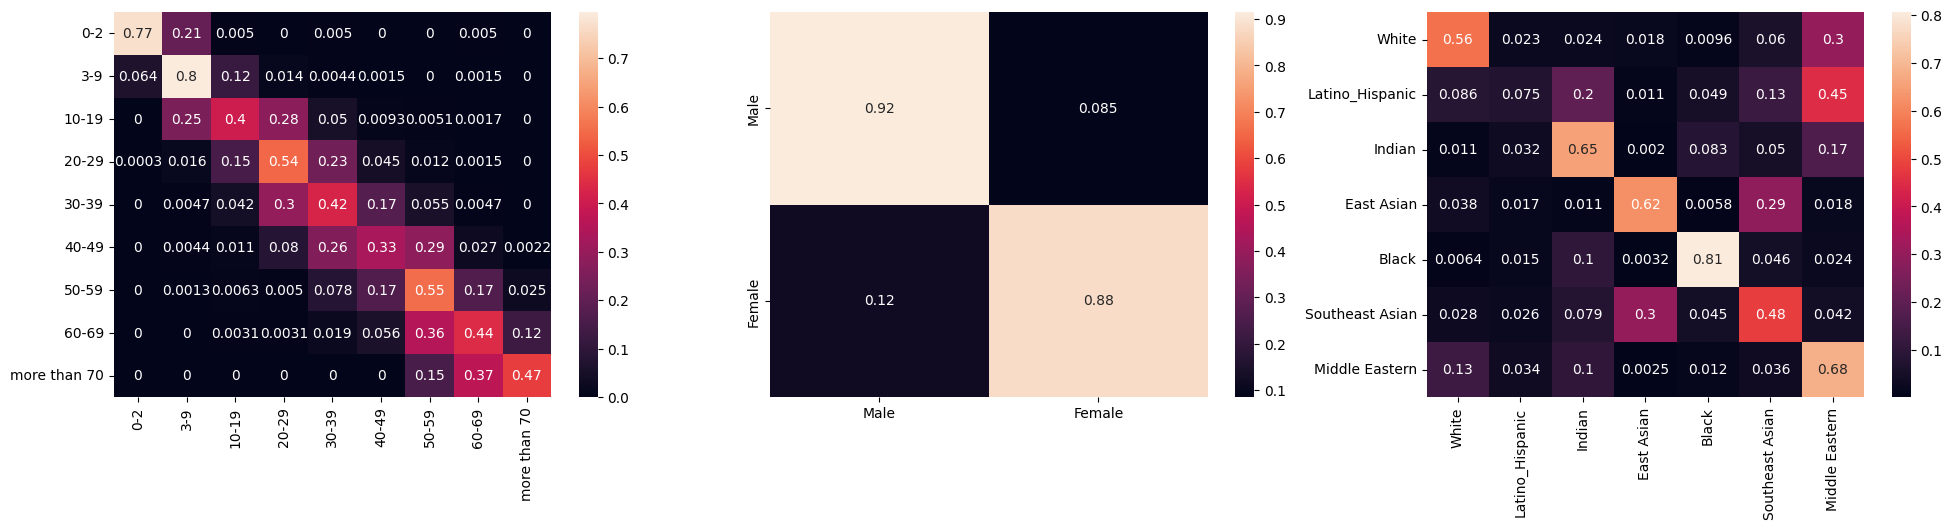

In [33]:
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}

ages, genders, races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [34]:
metrics.calc_measures(model, val_loader, device)

100%|██████████| 23/23 [00:06<00:00,  3.59it/s]


,accuracy,precision,recall,f1
age,0.508947,0.490461,0.526508,0.505228
gender,0.899215,0.899451,0.898248,0.898740
race,0.548293,0.548434,0.554255,0.526622


In [58]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

true_cat = 'Latino_Hispanic'
pred_cat = 'Middle Eastern'
mism_imgs = get_mismatched_classes(model, val_loader, true_cat, pred_cat, race_dict, 'race', device)
mism_imgs = [i.cpu() for i in mism_imgs]

100%|██████████| 22/22 [00:05<00:00,  3.84it/s]


In [59]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return self.unnormalize(x)

    def unnormalize(self, x):
        # Assuming x is a PyTorch tensor
        return x * self.std[None, :, None, None] + self.mean[None, :, None, None]

def show(imgs, true_cat, pred_cat):
    if not os.path.exists('../mismatched'):
        os.mkdir('../mismatched')
        
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(tqdm(imgs)):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title(f'True category = {true_cat}; Mismatched one = {pred_cat}')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

# Example Usage:
mean = [0.485, 0.456, 0.406]  # Replace with your actual mean values
std = [0.229, 0.224, 0.225]   # Replace with your actual standard deviation values

# Create an instance of Unnormalize
unnormalize = Unnormalize(mean=mean, std=std)
show([unnormalize(i).squeeze(0) for i in mism_imgs], true_cat, pred_cat)

100%|██████████| 435/435 [00:22<00:00, 19.62it/s]
